# **Electric Vehicle (EV) Sales Analysis in India**

## **Objective**

**The objective of this project is to analyze electric vehicle (EV) sales data across Indian states to understand adoption trends, regional performance, and vehicle category contribution. The analysis aims to identify growth patterns, leading states, dominant vehicle segments, and overall market expansion to support policy planning, infrastructure development, and investment decisions in the EV ecosystem.**

## **Dataset Overview**

**The dataset contains electric vehicle sales data across multiple Indian states, including information such as date, state, vehicle category, vehicle type/class, and EV sales quantity. The data represents real-world EV adoption patterns over multiple years.**

**Step 1: Importing Required Libraries**

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

**Step 2: Settings / Output Folders**

In [2]:
DATA_PATH = r"C:\Users\Prath\Downloads\Electric Vehicle Sales by State in India.csv"

OUT_DIR = "outputs_ev"
TABLES_DIR = os.path.join(OUT_DIR, "tables")
CHARTS_DIR = os.path.join(OUT_DIR, "charts")

os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR, exist_ok=True)

print(" Tables:", os.path.abspath(TABLES_DIR))
print(" Charts:", os.path.abspath(CHARTS_DIR))

 Tables: C:\Users\Prath\outputs_ev\tables
 Charts: C:\Users\Prath\outputs_ev\charts


**Step 3: Using Helper Functions**

In [3]:
def safe_filename(name: str) -> str:
    name = str(name).strip().lower()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    return name.strip("_") or "file"

def export_csv(df: pd.DataFrame, filename: str) -> str:
    path = os.path.join(TABLES_DIR, f"{safe_filename(filename)}.csv")
    df.to_csv(path, index=False, encoding="utf-8-sig")
    return os.path.abspath(path)

def save_and_show(filename: str, dpi: int = 180) -> str:
    path = os.path.join(CHARTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close()
    print(" Saved:", os.path.abspath(path))
    return os.path.abspath(path)

def detect_header_row(path: str, encoding: str = "latin1", max_lines: int = 250) -> int:
    with open(path, "rb") as f:
        lines = f.read().decode(encoding, errors="ignore").splitlines()

    keywords = ["state", "date", "sales"]
    best_idx = None

    for i, line in enumerate(lines[:max_lines]):
        low = line.lower()
        if ("state" in low) and ("date" in low) and (("sales" in low) or ("quantity" in low)):
            best_idx = i
            print(" Header found at row:", i)
            print("HEADER:", line)
            break

    # fallback if not detected: try to find line with many separators
    if best_idx is None:
        sep_candidates = [",", "\t", ";", "|"]
        scores = []
        for i, line in enumerate(lines[:max_lines]):
            score = max(line.count(sep) for sep in sep_candidates)
            scores.append((score, i, line))
        scores.sort(reverse=True)
        best_idx = scores[0][1]
        print(" Header not clearly found by keywords.")
        print("Using fallback header row:", best_idx)
        print("LINE:", scores[0][2])

    return best_idx

def robust_read_ev(path: str) -> pd.DataFrame:
    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin1", "ISO-8859-1"]
    last_err = None

    for enc in encodings:
        try:
            hdr = detect_header_row(path, encoding=enc)
            df = pd.read_csv(
                path,
                encoding=enc,
                engine="python",
                sep=None,              # auto delimiter detect
                skiprows=hdr,          # start from real header
                on_bad_lines="skip"
            )
            df.columns = [str(c).strip() for c in df.columns]
            # Basic validation: should have multiple columns and contain 'state' somewhere
            if df.shape[1] >= 3 and any("state" in c.lower() for c in df.columns):
                print(f" Loaded successfully with encoding='{enc}' | rows={len(df)} cols={df.shape[1]}")
                return df
        except Exception as e:
            last_err = e

    raise last_err

def to_numeric_clean(s: pd.Series) -> pd.Series:
    x = s.astype(str).str.replace(",", "", regex=False)
    x = x.str.replace(r"[^0-9.\-]+", "", regex=True)
    return pd.to_numeric(x, errors="coerce")



**Step 4: Load Data**

In [4]:
df_raw = robust_read_ev(DATA_PATH)
print("✅ Columns:", df_raw.columns.tolist())
display(df_raw.head())


 Header found at row: 0
HEADER: Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
 Loaded successfully with encoding='utf-8' | rows=96845 cols=8
✅ Columns: ['Year', 'Month_Name', 'Date', 'State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'EV_Sales_Quantity']


,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,1/1/2014,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,1/1/2014,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,1/1/2014,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,1/1/2014,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,1/1/2014,Andhra Pradesh,BUS,Bus,Bus,0.0


**Step 5: Column Mapping**

In [5]:
def pick_col(cols, must_contain):
    for c in cols:
        low = c.lower()
        if all(k in low for k in must_contain):
            return c
    return None

cols = df_raw.columns.tolist()

date_col = pick_col(cols, ["date"]) or next((c for c in cols if "date" in c.lower()), None)
state_col = pick_col(cols, ["state"]) or next((c for c in cols if "state" in c.lower()), None)

sales_col = pick_col(cols, ["sales", "quantity"])
if sales_col is None:
    # fallback: any column containing sales or quantity
    sales_col = next((c for c in cols if ("sales" in c.lower()) or ("quantity" in c.lower())), None)

veh_cat_col = pick_col(cols, ["vehicle", "category"]) or next((c for c in cols if "vehicle_category" in c.lower()), None)
veh_type_col = pick_col(cols, ["vehicle", "type"]) or next((c for c in cols if "vehicle_type" in c.lower()), None)
veh_class_col = pick_col(cols, ["vehicle", "class"]) or next((c for c in cols if "vehicle_class" in c.lower()), None)

print(" Detected columns:")
print("Date:", date_col)
print("State:", state_col)
print("Sales:", sales_col)
print("Vehicle_Category:", veh_cat_col)
print("Vehicle_Type:", veh_type_col)
print("Vehicle_Class:", veh_class_col)

if date_col is None or state_col is None or sales_col is None:
    raise ValueError("Required columns not detected. Please paste df_raw.columns.tolist() here and I will map it manually.")



 Detected columns:
Date: Date
State: State
Sales: EV_Sales_Quantity
Vehicle_Category: Vehicle_Category
Vehicle_Type: Vehicle_Type
Vehicle_Class: Vehicle_Class


**Step 6: Data Cleaning & Feature Engineering**

In [6]:
df = df_raw.copy()

df["Date"] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
df["State"] = df[state_col].astype(str).str.strip()
df["EV_Sales_Quantity"] = to_numeric_clean(df[sales_col])

# Optional columns
df["Vehicle_Category"] = df[veh_cat_col].astype(str).str.strip() if veh_cat_col else "Unknown"
df["Vehicle_Type"] = df[veh_type_col].astype(str).str.strip() if veh_type_col else "Unknown"
df["Vehicle_Class"] = df[veh_class_col].astype(str).str.strip() if veh_class_col else "Unknown"

# Remove duplicates + invalid rows
dup = int(df.duplicated().sum())
df = df.drop_duplicates().copy()

before = len(df)
df = df[df["Date"].notna() & df["State"].notna() & df["EV_Sales_Quantity"].notna()].copy()
df = df[df["EV_Sales_Quantity"] > 0].copy()
removed = before - len(df)

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.to_period("M").astype(str)
df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)

print(f" Duplicates removed: {dup}")
print(f" Invalid rows removed: {removed}")
print(" Final rows:", len(df))

export_csv(df, "ev_sales_cleaned")



 Duplicates removed: 0
 Invalid rows removed: 82783
 Final rows: 14062


'C:\\Users\\Prath\\outputs_ev\\tables\\ev_sales_cleaned.csv'

**Step 7: KPIs Summary 

In [7]:
kpi = pd.DataFrame([{
    "Total_EV_Sales": float(df["EV_Sales_Quantity"].sum()),
    "States_Covered": int(df["State"].nunique()),
    "Start_Date": df["Date"].min(),
    "End_Date": df["Date"].max(),
    "Total_Records": int(len(df)),
    "Avg_Monthly_Sales": float(df.groupby("Month")["EV_Sales_Quantity"].sum().mean())
}])
export_csv(kpi, "kpi_summary")
display(kpi)

dq = pd.DataFrame([
    {"metric": "raw_rows", "value": len(df_raw)},
    {"metric": "duplicates_removed", "value": dup},
    {"metric": "invalid_rows_removed", "value": removed},
    {"metric": "final_rows", "value": len(df)},
])
export_csv(dq, "dq_summary")
display(dq)

,Total_EV_Sales,States_Covered,Start_Date,End_Date,Total_Records,Avg_Monthly_Sales
0,3593811.0,34,2014-01-01,2024-01-01,14062,326710.090909


,metric,value
0,raw_rows,96845
1,duplicates_removed,0
2,invalid_rows_removed,82783
3,final_rows,14062


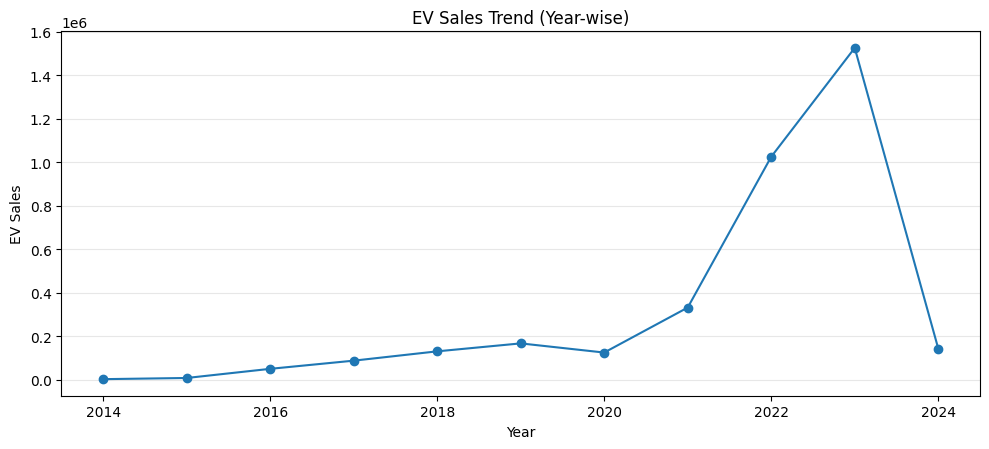

 Saved: C:\Users\Prath\outputs_ev\charts\year_trend.png


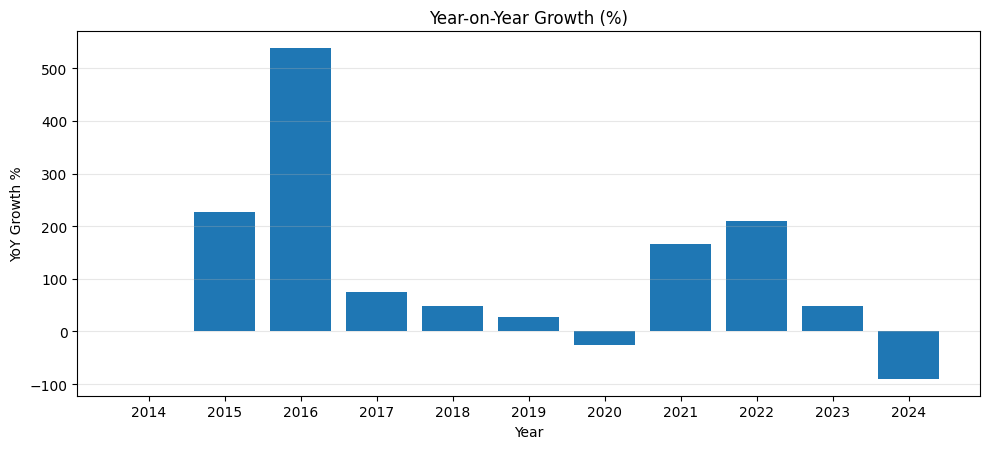

 Saved: C:\Users\Prath\outputs_ev\charts\yoy_growth.png


'C:\\Users\\Prath\\outputs_ev\\charts\\yoy_growth.png'

In [8]:
# A) Year trend + YoY
year_trend = df.groupby("Year", as_index=False)["EV_Sales_Quantity"].sum().sort_values("Year")
year_trend["YoY_Growth_%"] = year_trend["EV_Sales_Quantity"].pct_change() * 100
export_csv(year_trend, "year_trend_yoy")

plt.figure(figsize=(10, 4.6))
plt.plot(year_trend["Year"], year_trend["EV_Sales_Quantity"], marker="o")
plt.title("EV Sales Trend (Year-wise)")
plt.xlabel("Year")
plt.ylabel("EV Sales")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("year_trend.png")

plt.figure(figsize=(10, 4.6))
plt.bar(year_trend["Year"].astype(str), year_trend["YoY_Growth_%"].fillna(0))
plt.title("Year-on-Year Growth (%)")
plt.xlabel("Year")
plt.ylabel("YoY Growth %")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("yoy_growth.png")


#### Year-wise EV Sales Trend
**Chart Purpose:
This chart shows how EV sales have changed year by year, highlighting the overall adoption trend in India.**

**Business Use:
Helps policymakers and industry stakeholders evaluate whether EV adoption is accelerating and assess the long-term effectiveness of EV initiatives and incentives.**

#### Year-on-Year (YoY) Growth Analysis

**Chart Purpose:
This chart displays the percentage change in EV sales compared to the previous year, indicating periods of rapid growth or slowdown.**

**Business Use:
Useful for measuring market momentum and understanding the impact of new policies, subsidies, or infrastructure investments on EV adoption.**

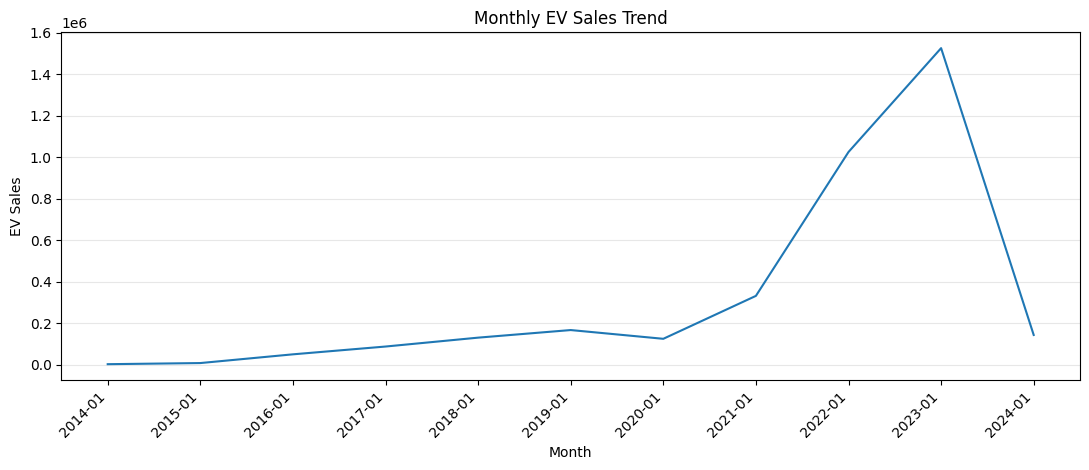

 Saved: C:\Users\Prath\outputs_ev\charts\monthly_trend.png


'C:\\Users\\Prath\\outputs_ev\\charts\\monthly_trend.png'

In [9]:
# B) Monthly trend
monthly = df.groupby("Month", as_index=False)["EV_Sales_Quantity"].sum()
monthly["m_dt"] = pd.to_datetime(monthly["Month"], errors="coerce")
monthly = monthly.sort_values("m_dt").drop(columns=["m_dt"])
export_csv(monthly, "monthly_trend")

plt.figure(figsize=(11, 4.8))
plt.plot(monthly["Month"], monthly["EV_Sales_Quantity"])
plt.title("Monthly EV Sales Trend")
plt.xlabel("Month")
plt.ylabel("EV Sales")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("monthly_trend.png")

**Chart Purpose:
This chart highlights month-wise EV sales patterns and possible seasonality in adoption.**

**Business Use:
Supports planning of promotional campaigns, inventory management, and operational readiness during high-demand periods.**

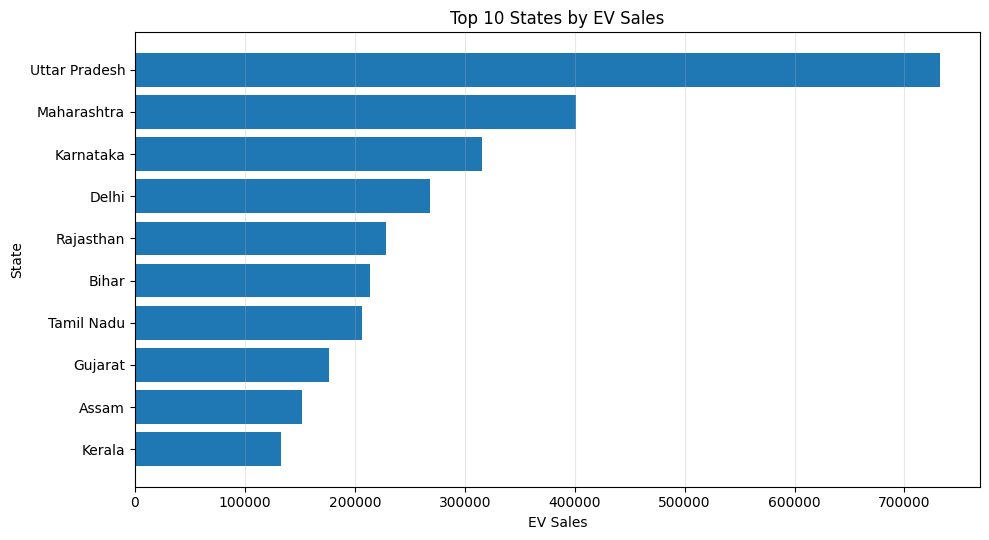

 Saved: C:\Users\Prath\outputs_ev\charts\top_10_states.png


'C:\\Users\\Prath\\outputs_ev\\charts\\top_10_states.png'

In [10]:
# C) Top 10 states
top_states = (df.groupby("State", as_index=False)["EV_Sales_Quantity"].sum()
              .sort_values("EV_Sales_Quantity", ascending=False).head(10))
export_csv(top_states, "top_10_states")

plt.figure(figsize=(10, 5.5))
plt.barh(top_states["State"][::-1], top_states["EV_Sales_Quantity"][::-1])
plt.title("Top 10 States by EV Sales")
plt.xlabel("EV Sales")
plt.ylabel("State")
plt.grid(True, axis="x", alpha=0.3)
save_and_show("top_10_states.png")

**Chart Purpose:
This chart identifies the top-performing states based on total EV sales volume.**

**Business Use:
Helps prioritize regions for charging infrastructure development, dealership expansion, and targeted state-level policy interventions.**

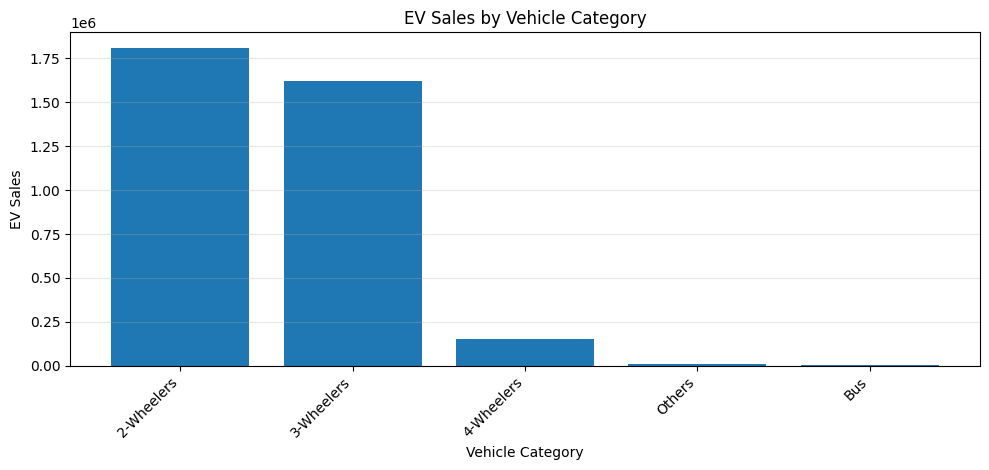

 Saved: C:\Users\Prath\outputs_ev\charts\vehicle_category_mix.png


'C:\\Users\\Prath\\outputs_ev\\charts\\vehicle_category_mix.png'

In [11]:
# D) Category mix
cat_mix = (df.groupby("Vehicle_Category", as_index=False)["EV_Sales_Quantity"].sum()
           .sort_values("EV_Sales_Quantity", ascending=False))
cat_mix["Share_%"] = 100 * cat_mix["EV_Sales_Quantity"] / cat_mix["EV_Sales_Quantity"].sum()
export_csv(cat_mix, "vehicle_category_mix")

plt.figure(figsize=(10, 4.8))
plt.bar(cat_mix["Vehicle_Category"].astype(str), cat_mix["EV_Sales_Quantity"])
plt.title("EV Sales by Vehicle Category")
plt.xlabel("Vehicle Category")
plt.ylabel("EV Sales")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("vehicle_category_mix.png")


**Chart Purpose:
This chart shows the distribution of EV sales across different vehicle categories such as two-wheelers, three-wheelers, and four-wheelers.**

**Business Use:
Assists manufacturers and planners in focusing on vehicle segments that drive EV adoption and aligning production and policy strategies accordingly.**

,States_for_80%_Sales,Total_States
0,10,34


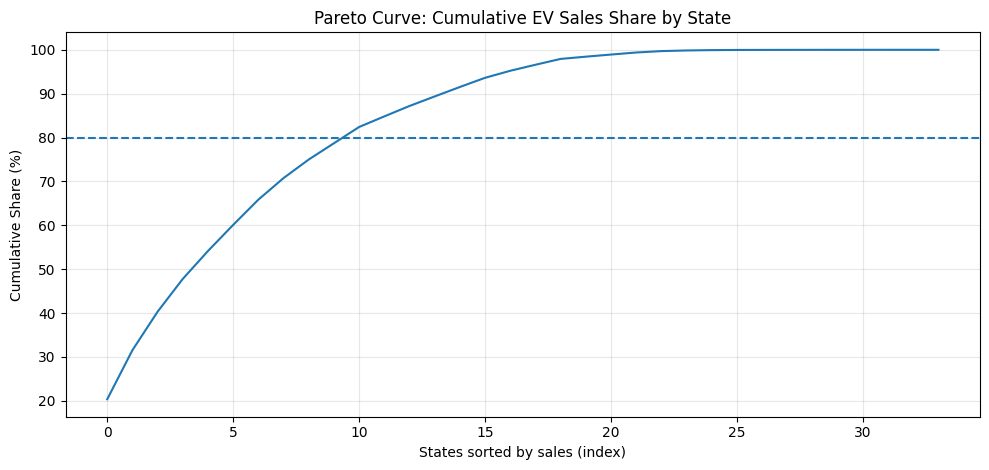

 Saved: C:\Users\Prath\outputs_ev\charts\pareto_curve_states.png


'C:\\Users\\Prath\\outputs_ev\\charts\\pareto_curve_states.png'

In [12]:
# A) Pareto for states
state_pareto = (df.groupby("State", as_index=False)["EV_Sales_Quantity"].sum()
                .sort_values("EV_Sales_Quantity", ascending=False))
state_pareto["Share_%"] = 100 * state_pareto["EV_Sales_Quantity"] / state_pareto["EV_Sales_Quantity"].sum()
state_pareto["Cumulative_%"] = state_pareto["Share_%"].cumsum()
export_csv(state_pareto, "state_pareto")

states_for_80 = int((state_pareto["Cumulative_%"] <= 80).sum())
pareto_summary = pd.DataFrame([{
    "States_for_80%_Sales": states_for_80,
    "Total_States": int(state_pareto.shape[0])
}])
export_csv(pareto_summary, "pareto_summary")
display(pareto_summary)

plt.figure(figsize=(10, 4.8))
plt.plot(state_pareto["Cumulative_%"].values)
plt.axhline(80, linestyle="--")
plt.title("Pareto Curve: Cumulative EV Sales Share by State")
plt.xlabel("States sorted by sales (index)")
plt.ylabel("Cumulative Share (%)")
plt.grid(True, alpha=0.3)
save_and_show("pareto_curve_states.png")


#### **Pareto Analysis (State-wise Contribution)**

**Chart Purpose:
This analysis checks whether a small number of states contribute a large portion of total EV sales, following the 80/20 principle.**

**Business Use:
Supports focused investment decisions by identifying high-impact states that contribute most to EV adoption.**

#### **State Growth Comparison (Early vs Recent Period)**
**Chart Purpose:
This analysis compares EV sales in earlier years with recent years to identify emerging and fast-growing states.**

**Business Use:
Helps detect newly growing markets early and plan infrastructure or incentives proactively.**

In [16]:
# B) CAGR
if year_trend["Year"].nunique() >= 2:
    start_year = int(year_trend.iloc[0]["Year"])
    end_year = int(year_trend.iloc[-1]["Year"])
    start_val = float(year_trend.iloc[0]["EV_Sales_Quantity"])
    end_val = float(year_trend.iloc[-1]["EV_Sales_Quantity"])
    years = max(1, end_year - start_year)

    cagr = ((end_val / start_val) ** (1 / years) - 1) * 100 if start_val > 0 else np.nan
else:
    cagr = np.nan

cagr_df = pd.DataFrame([{"CAGR_%": cagr}])
export_csv(cagr_df, "cagr")
display(cagr_df)

,CAGR_%
0,50.561081


**Chart Purpose:
CAGR measures the average annual growth rate of EV sales over the analysis period, providing a single metric to evaluate long-term growth.**

**Business Use:
Useful for investors, policymakers, and planners to assess the sustainability and pace of EV market expansion.**

#### **Business Use**

**The insights from this EV sales analysis can help:**

**Policymakers evaluate the effectiveness of EV incentives and regulations**
 
**Plan charging infrastructure and grid capacity based on regional demand**

**Support manufacturers in aligning product strategy with high-growth segments**

**Guide investors toward high-adoption and fast-growing states**

**Enable data-driven planning for sustainable mobility and emission reduction**

### **Conclusion**

**This project analyzed electric vehicle sales data across Indian states to understand adoption trends, regional concentration, and 
vehicle category performance. Through data cleaning, KPI reporting, trend analysis, and advanced techniques such as CAGR 
and Pareto analysis, meaningful insights were derived from real-world EV data.
The analysis confirms that EV adoption in India is growing rapidly, with strong concentration in specific states and dominance of 
certain vehicle categories. These insights can support strategic decision-making in policy formulation, infrastructure development, 
and investment planning. Overall, this project demonstrates a complete data analyst workflow with a strong focus on business relevance and 
real-world impact.**